In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [20]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
for obj in inspector.get_columns('measurement'):
    print(f"{obj['name']}: {obj['type']}")

id: INTEGER
station: TEXT
date: TEXT
prcp: FLOAT
tobs: FLOAT


In [29]:
for obj in inspector.get_columns('station'):
    print(f"{obj['name']}: {obj['type']}")

id: INTEGER
station: TEXT
name: TEXT
latitude: FLOAT
longitude: FLOAT
elevation: FLOAT


In [154]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [155]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [143]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
data_start_date = session.query(Measurement).order_by(Measurement.date).first()
data_end_date = session.query(Measurement).order_by(Measurement.date.desc()).first()

query_beg = dt.datetime.strptime(data_end_date.date,'%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precipscores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=query_beg).order_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(precipscores.statement, precipscores.session.bind)
df = df.set_index('date')
# Sort the dataframe by date(already sorted)

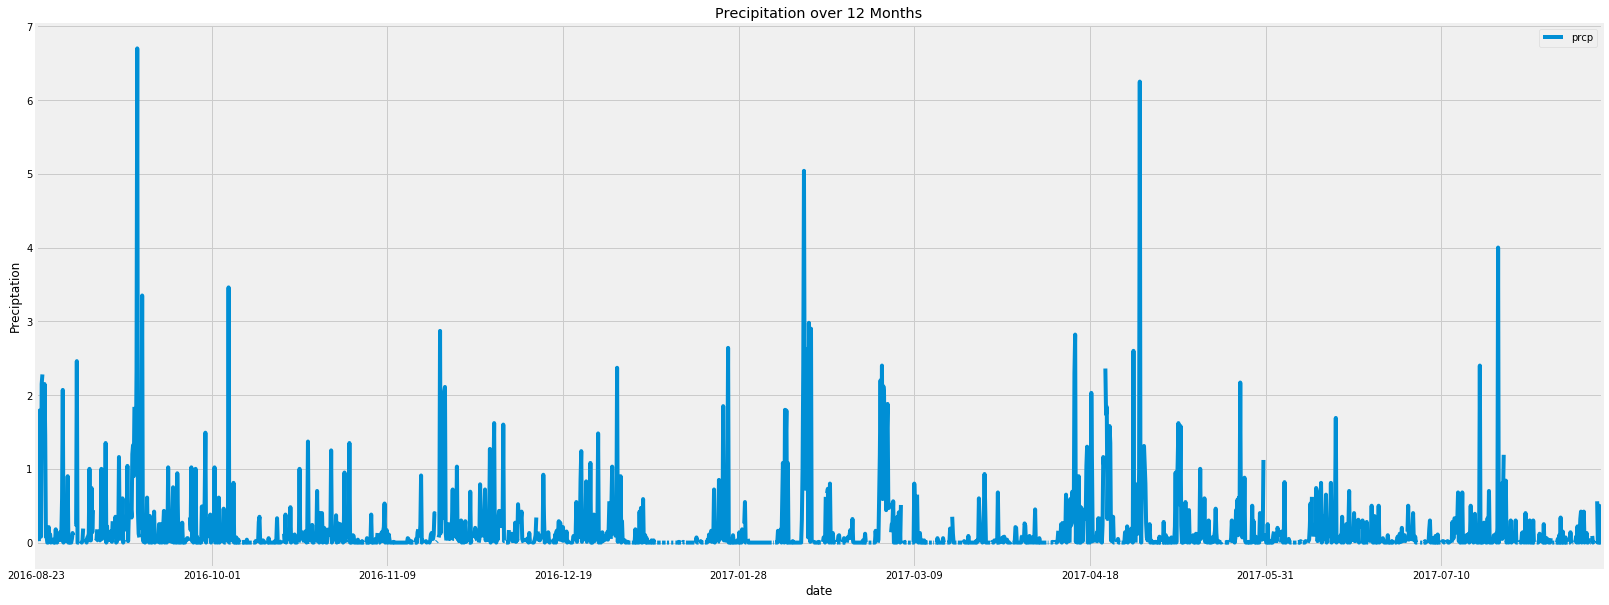

In [144]:
ax = df.plot(xticks=None,figsize=(25,10));
ax.set_ylabel('Preciptation');
ax.set_title('Precipitation over 12 Months');

In [145]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [152]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.name).all()
print(f"# of stations: {len(stations)}")

# of stations: 9


In [184]:
joined_data= session.query(Measurement.id, Measurement.station, Measurement.date,Measurement.prcp, Measurement.tobs, 
                            Station.elevation, Station.name, Station.latitude, Station.longitude)\
                            .filter(Measurement.station == Station.station)

In [231]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(func.count(Station.name), Station.name, Station.id)\
                            .group_by(Measurement.station).filter(Measurement.station == Station.station)\
                            .order_by(func.count(Station.name).desc())

# List the stations and the counts in descending order.
for obj in active_stations:
    print(obj)
    
most_active_station = active_stations[0][2]

(2772, 'WAIHEE 837.5, HI US', 7)
(2724, 'WAIKIKI 717.2, HI US', 1)
(2709, 'KANEOHE 838.1, HI US', 2)
(2669, 'WAIMANALO EXPERIMENTAL FARM, HI US', 6)
(2612, 'MANOA LYON ARBO 785.2, HI US', 9)
(2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 3)
(1979, 'HONOLULU OBSERVATORY 702.2, HI US', 8)
(1372, 'PEARL CITY, HI US', 4)
(511, 'UPPER WAHIAWA 874.3, HI US', 5)


In [235]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# Most active station is station 7

lowest_temp = session.query(Station.name, Measurement.tobs).filter(Measurement.station == Station.station).filter(Station.id == 7).order_by(Measurement.tobs).first()
highest_temp = session.query(Station.name, Measurement.tobs).filter(Measurement.station == Station.station).filter(Station.id == 7).order_by(Measurement.tobs.desc()).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == Station.station).filter(Station.id == 7).first()

print(f"Station {most_active_station}\n\
Lowest Temp: {lowest_temp[1]}\n\
Highest Temp: {highest_temp[1]}\n\
Average Temp: {avg_temp[0]:.1f}")

Station 7
Lowest Temp: 54.0
Highest Temp: 85.0
Average Temp: 71.7


In [247]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
station_7 = session.query(Measurement.tobs).filter(Measurement.station == Station.station)\
            .filter(Station.id == 7).filter(Measurement.date>=query_beg)

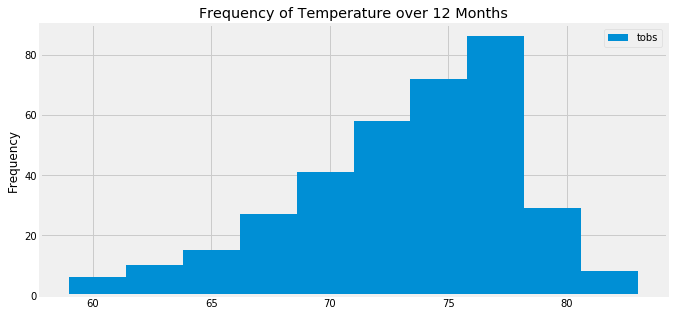

In [250]:
#plot the results as a histogram
df = pd.read_sql(station_7.statement, station_7.session.bind)

ax = df.plot.hist(xticks=None,figsize=(10,5));
ax.set_title('Frequency of Temperature over 12 Months');

In [252]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [330]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_begin = '2017-08-09'
trip_end = '2017-08-16'
trip_stats = calc_temps('2017-08-09', '2017-08-16')

tmin = trip_stats[0][0]
tavg = trip_stats[0][1]
tmax = trip_stats[0][2]

print(f"Statistics for {trip_begin} through {trip_end}:\n\
Min: {tmin}\n\
Avg: {tavg:.1f}\n\
Max: {tmax}")

Statistics for 2017-08-09 through 2017-08-16:
Min: 70.0
Avg: 78.4
Max: 84.0


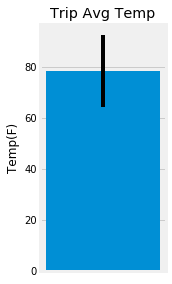

In [331]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure(figsize=(2,10))
ax = fig.add_subplot("211")
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')
ax.set_xticks(ticks=[])
ax = plt.bar(x=0, height=trip_stats[0][1], width=1,yerr=(tmax - tmin));

In [348]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
           filter(Measurement.station == Station.station).filter(Measurement.date.between(trip_begin,trip_end)).\
           group_by(Station.name).order_by(func.sum(Measurement.prcp).desc())
rainfall_df = pd.read_sql(rainfall.statement,rainfall.session.bind)
rainfall_df = rainfall_df.rename(columns={"sum_1":"Total Precip.","station":"Station ID","name":"Station Name"})
rainfall_df


,Total Precip.,Station ID,Station Name,latitude,longitude,elevation
0,1.42,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.44,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.21,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,0.02,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,0.01,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


## Optional Challenge Assignment

In [349]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [437]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
trip_begin_dt = dt.datetime.strptime(trip_begin,'%Y-%m-%d')
trip_end_dt = dt.datetime.strptime(trip_end,'%Y-%m-%d')

datelist = []
Date = trip_begin_dt
while Date <= trip_end_dt:
    datelist.append(dt.date(Date.year,Date.month,Date.day))
    Date = Date + dt.timedelta(days=1)
    
# Stip off the year and save a list of %m-%d strings
date_string_list = []
for date in datelist:
    date_string_list.append('{:02}'.format(date.month)+'-'+'{:02}'.format(date.day))
 
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in date_string_list:
    normals.append(daily_normals(date)[0])

'2017-08-09'

In [439]:
datestring = []
for date in datelist:
    datestring.append(date.strftime("%Y-%m-%d"))
datestring

['2017-08-09',
 '2017-08-10',
 '2017-08-11',
 '2017-08-12',
 '2017-08-13',
 '2017-08-14',
 '2017-08-15',
 '2017-08-16']

In [442]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
headers = ['TMin', 'TAvg', 'TMax']
normals_df = pd.DataFrame.from_records(normals, columns=headers)
normals_df['Date'] = datestring
normals_df.set_index('Date')

,TMin,TAvg,TMax
Date,,,
2017-08-09,69.0,75.980392,81.0
2017-08-10,65.0,76.420000,83.0
2017-08-11,67.0,75.981132,82.0
2017-08-12,67.0,76.527273,83.0
2017-08-13,71.0,76.982456,84.0
2017-08-14,71.0,76.777778,82.0
2017-08-15,69.0,76.471698,83.0
2017-08-16,69.0,76.080000,83.0


Text(0, 0.5, 'Temp(F)')

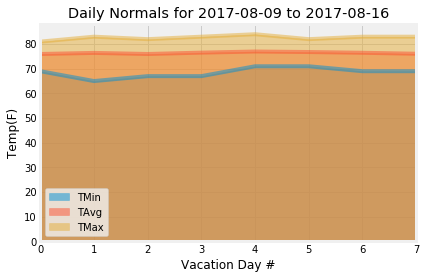

In [447]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False);
ax.set_title(f"Daily Normals for {trip_begin} to {trip_end}");
ax.set_xlabel("Vacation Day #");
ax.set_ylabel("Temp(F)")